In [2]:
import pandas as pd
import numpy as np
import re
import string
import calendar
import nltk 

In [3]:
ori_twit_sexism_dataset = '/Users/churnika/Desktop/Projects/Crime_classification/dataset/twitter_sexism_parsed_dataset.csv'
ori_twit_sexism = pd.read_csv(ori_twit_sexism_dataset)
ori_twit_sexism = ori_twit_sexism.dropna()
ori_twit_sexism.columns

Index(['index', 'id', 'Text', 'Annotation', 'oh_label'], dtype='object')

In [4]:
ori_twit_sexism = ori_twit_sexism.drop(columns=['index','id','Annotation'])
print(ori_twit_sexism.columns)

Index(['Text', 'oh_label'], dtype='object')


In [5]:
msg_exp = ori_twit_sexism['Text'].str.lower()

In [6]:
# removing the urls that are present.

text_without_urls = []

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text_without_urls = url_pattern.sub('',text)
    return text_without_urls

for i in range(len(msg_exp)):
    try:
        msg_exp[i] = remove_urls(msg_exp[i])
    except KeyError as e:
        # print(f"Error at index {i}: {e}. Skipping...")
        continue

In [7]:
# removing punctuations

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

for i in range(len(msg_exp)):
    try:
        msg_exp[i] = remove_punctuation(msg_exp[i])

    except KeyError as e:
        # print(f"Error at index {i}: {e}. Skipping...")
        continue

In [8]:
# TOKENIZATION
# REMOVING URLS
# REMOVING NUMBERS
# REMOVING STOP WORDS

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

months_days = [calendar.month_name[i].lower() for i in range(1, 13)] + [calendar.day_name[i].lower() for i in range(7)]
remove_words = ["vo","n","m","c","ra","xx","r","date","hii","hi","ye","pa","xxx","p","sir","mam","good","morning","time","ur","you","status","father"]

cleaned_tokens = []

for i in range(len(msg_exp)):
    try:
        tokens = nltk.word_tokenize(msg_exp[i])
        # Filter out URLs
        tokens = [token for token in tokens if not re.match(r'http[s]?://', token)]
        tokens = [token for token in tokens if token.isalpha()]
        tokens = [token for token in tokens if token not in stop_words]
        tokens = [token for token in tokens if token not in months_days]
        tokens = [token for token in tokens if token not in remove_words]
        cleaned_tokens.append(tokens)
    except Exception as e:
        print(f"Error at index {i}: {e}. Skipping...")
        continue

[nltk_data] Downloading package punkt to /Users/churnika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Error at index 9781: 9781. Skipping...
Error at index 9782: 9782. Skipping...
Error at index 9783: 9783. Skipping...


In [9]:
# LEMMATIZATION

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [[lemmatizer.lemmatize(token) for token in tokens]for tokens in cleaned_tokens]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/churnika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# REMOVING RARE OR FREQUENTLY USED WORDS

from collections import Counter

freq = Counter([token for tokens in lemmatized_tokens for token in tokens])
freq_threshold = 10

lemmatized_tokens = [[token for token in tokens if freq[token] > freq_threshold] for tokens in lemmatized_tokens]

In [11]:
#REMOVING WHITESPACES

cleaned_lemmatized_tokens = [' '.join(tokens) for tokens in lemmatized_tokens]
cleaned_lemmatized_tokens = [text.split() for text in cleaned_lemmatized_tokens]

In [12]:
# Dictionary mapping abbreviations to their full forms
abbreviation_dict = {
    "don't": "do not",
    "can't": "cannot",
    "u": "you",
    "rt": "right",
    "ur":"your"
}

# Function to expand abbreviations
def expand_abbreviations(tokens):
    expanded_tokens = []
    for token in tokens:
        if token in abbreviation_dict:
            expanded_tokens.extend(abbreviation_dict[token].split())
        else:
            expanded_tokens.append(token)
    return expanded_tokens

# Expand abbreviations in cleaned_lemmatized_tokens
expanded_lemmatized_tokens = [expand_abbreviations(tokens) for tokens in cleaned_lemmatized_tokens]

In [13]:
#REMOVE ACCENTS AND DIACRITICS FROM EXPANDED_LEMMATIZED_TOKENS

from unidecode import unidecode

def remove_accents_diacritics(tokens):
    cleaned_tokens = []
    for token in tokens:
        cleaned_token = unidecode(token)
        cleaned_tokens.append(cleaned_token)
    return cleaned_tokens

expanded_lemmatized_tokens = [remove_accents_diacritics(tokens) for tokens in expanded_lemmatized_tokens]


In [14]:
# PART-OF-SPEECH

pos_tagged_tokens = [nltk.pos_tag(tokens) for tokens in expanded_lemmatized_tokens]

In [16]:
# VECTORIZATION

from sklearn.feature_extraction.text import TfidfVectorizer

joined_tokens = [' '.join(tokens) for tokens in expanded_lemmatized_tokens]

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(joined_tokens)


In [17]:
# SENTIMENT ANALYSIS

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

tokens = expanded_lemmatized_tokens

# Function to get sentiment
def get_sentiment(token_list):
    text = ' '.join(token_list)
    sentiment = sia.polarity_scores(text)
    return sentiment

sentiments = [get_sentiment(token_list) for token_list in tokens]

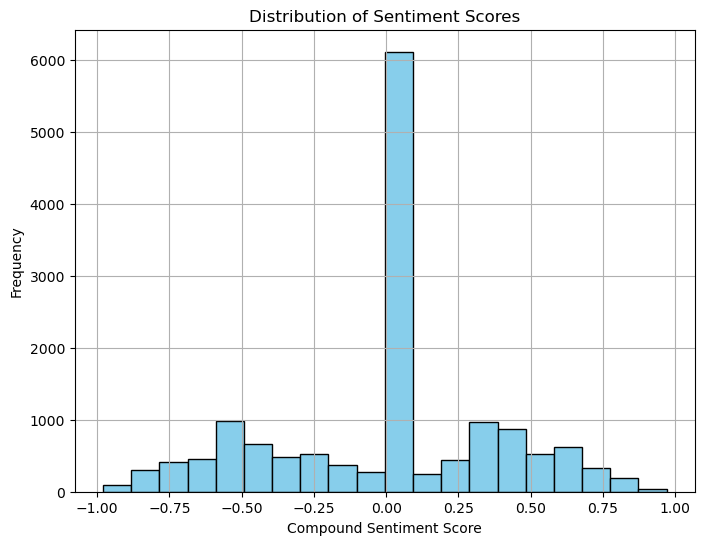

In [19]:
import matplotlib.pyplot as plt

compound_scores = [sentiment['compound'] for sentiment in sentiments]

plt.figure(figsize=(8, 6))
plt.hist(compound_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
# MAPPING SENTIMENTS TO y

def map_sentiment_score_to_label(sentiment):
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

sentiment_labels = [map_sentiment_score_to_label(sentiment) for sentiment in sentiments]

# ori_twit_sexism['sentiment'] = sentiment_labels


In [23]:
print(len(ori_twit_sexism))
print(len(sentiment_labels))

14878
14875


In [18]:
print(sentiments)
# print(pos_tagged_tokens)
# print(expanded_lemmatized_tokens)
# print(cleaned_lemmatized_tokens)

[{'neg': 0.227, 'neu': 0.584, 'pos': 0.19, 'compound': -0.1471}, {'neg': 0.425, 'neu': 0.575, 'pos': 0.0, 'compound': -0.5719}, {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.2732}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.192, 'neu': 0.439, 'pos': 0.369, 'compound': 0.3441}, {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.532, 'pos': 0.468, 'compound': 0.5267}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.183, 'neu': 0.522, 'pos': 0.296, 'compound': 0.3182}, {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.6808}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.42, 'neu': 0.58, 'pos': 0.0, 'compound': -0.4404}, {'neg': 0.0, 'neu': 0.435, 'pos': 0.565, 'compound': 0.0772}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compo

In [ ]:
print(cleaned_tokens)

[['rt', 'beepss', 'beepss', 'im', 'sexist', 'fuck', 'youre', 'woman', 'cant', 'cook', 'get', 'shit', 'together'], ['theres', 'hate', 'able', 'teams', 'year', 'mkr'], ['rt', 'theeccles', 'everyone', 'underestimated', 'us', 'still', 'well', 'underestimating', 'judging', 'mkr'], ['rt', 'notlukedarcy', 'mkr', 'actually', 'check', 'people', 'could', 'cook', 'witb'], ['dont', 'shutupjeff', 'thought', 'really', 'funny', 'joke', 'promise', 'im', 'sexist', 'say'], ['rt', 'wateronatrain', 'might', 'like', 'patriarchy'], ['rt', 'bet', 'campers', 'vote', 'strategicallyat', 'least', 'kat', 'say', 'mkr'], ['evvykube', 'absurd', 'much', 'amazon', 'wish', 'list', 'consists', 'socks'], ['rt', 'daniellevlee', 'colin', 'obviously', 'malnourished', 'cooking', 'cause', 'sounds', 'delirious', 'mkr'], ['newscoverup', 'rjennromao', 'gbabeuf', 'novorossiyan', 'gbazov', 'russias', 'army', 'internet', 'trolls'], ['rt', 'metalbarbiedoll', 'yea', 'apparently', 'gamergate', 'women', 'sock', 'puppetslol'], ['notice'

In [ ]:
# print(text_without_urls[785])

In [ ]:
print(len(cleaned_tokens[3]))


9
